# Titanic data analysis

In this notebook, I am trying to answer my main question:
"How is the survival chance in relation to age, gender, money and location ?"
- The train data is collected from this [link](https://www.kaggle.com/c/titanic/download/train.csv)
- The description of data from this [link](https://www.kaggle.com/c/titanic/data)

In [1]:
#Select libraries for this data analysis
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sp
import math
import titanic_statistic as ts #a library that have some statistical tests
%matplotlib inline

Firstly, I import the data into notebook by using DataFrame in pandas library.

In [2]:
#import data
titanic = pd.read_csv('titanic_data.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Checking the format of this data

In [3]:
titanic.shape

(891, 12)

In [4]:
titanic.Name.nunique()

891

Now we know that we have 891 observations without duplication and 12 catergory to investigate this dataset.

In [5]:
#checking the missing values or NaN in this dataset
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

There are missing values in Age, Cabin and Embarked columns. In order to get a good estimation, the best approach is ignoring those missing values in data analysis.

After I knew the format of this data, it is time to dive into this dataset to answer my main curiosity.

## How is the distribution of age in this tragedy ?

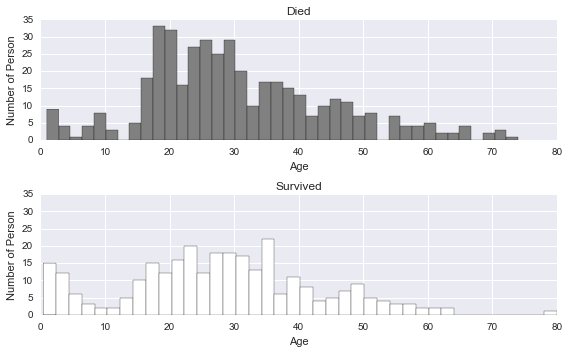

In [6]:
#make plot to age distribution related to survival
fig = plt.figure()
fig.set_size_inches(8,5)

ax1 = fig.add_subplot(211)
ax1.hist(titanic[(titanic.Survived==0)].Age.dropna(),bins=40,color='grey')
ax1.set_title('Died')
ax1.set_xlabel('Age')
ax1.set_ylabel('Number of Person')

ax2 = fig.add_subplot(212)
ax2.hist(titanic[(titanic.Survived==1)].Age.dropna(),color= 'w',bins=40)
ax2.set_title('Survived')
ax2.set_xlabel('Age')
ax2.set_ylabel('Number of Person')
ax2.set_ylim([0,35])
plt.tight_layout()
plt.show()

By choosing 40 bins, I can have a smooth distribution of age (2 years/bin) when the range from 0 to 80. I decided to seperate into two group: Died and Survival. This seperation will help to gain better insight the data. As we see on the above graph, most of people were died at age from 20 to 70 in this tragedy.  The interesting point is that there is one 80 years-old person who was survived. Here is the detail of that lucky man.

In [7]:
titanic[((titanic.Survived==1)&(titanic.Age>78))]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
630,631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.0,0,0,27042,30.0,A23,S


In [8]:
#calculate the survivability of children under 10
survived_child = len(titanic[((titanic['Survived']==1)&(titanic['Age'] < 10))])
total_child = len(titanic[((titanic['Age'] < 10))])
survived_child*1.0/total_child

0.6129032258064516

The survival ratio of children is high (0.61) on this Titanic. Next, it is interesting to study about the survival distribution in gender excluding children (below 10 years old).

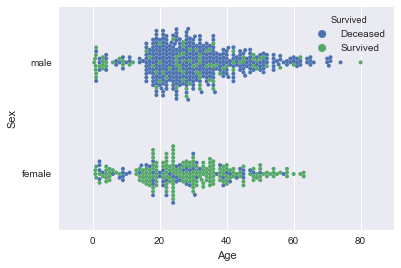

Sex,female,male
Survived,,
0,52,346
1,178,74


In [9]:
#make plot to gender distribution related to survival
df = titanic[titanic.Age>10].groupby(['Survived','Sex']).PassengerId.count().unstack(level=1)
sns.swarmplot(x='Age',y='Sex',hue=titanic.Survived.map({0:'Deceased',1:'Survived'}),data=titanic,size=4)
plt.show()
df

Most of men were died and most of women were survived in this tragedy. In this plot, the life/death ratio in gender is difference. While this ratio in male is 0.213, this ratio in female is 3.423. In conclusion, women and children get higher change to be alive in this tragedy.

To continue our analysis, let move to the next category, the effect of money or economic status. Does economic level increase the survival change ? Let take a look at distribution of Pclass and Fare on this Titanic.

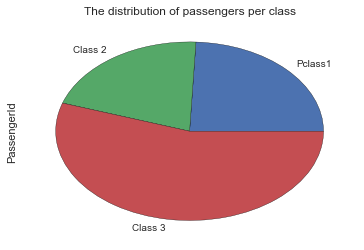

Pclass
1    216
2    184
3    491
Name: PassengerId, dtype: int64

In [10]:
#make plot to class distribution in Titanic
data1 = titanic.groupby('Pclass',as_index=True).count()
data1.PassengerId.plot(kind='pie',labels=['Pclass1','Class 2','Class 3'])
plt.title('The distribution of passengers per class')
plt.show()
data1.PassengerId

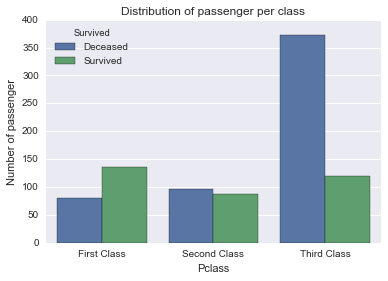

In [11]:
#make plot to age distribution related to survival
data2 = titanic.groupby(['Survived','Pclass']).count().reset_index()
sns.barplot(x=data2.Pclass.map({1:'First Class', 2:'Second Class', 3:'Third Class'}),
            y=data2.PassengerId,
            hue=data2.Survived.map({0:'Deceased',1:'Survived'}))
plt.ylabel("Number of passenger")
plt.title('Distribution of passenger per class')
plt.show()

Obviously, there is difference in life/death ratio among 3 classes. In middle class, the number of death and alive is closely equal. In low class, more people were died than alive. However, there is more number of survival people than death in top class. Will we have higher chance to survive when stayed in top class?. To answer this question, I used statistical test in categorical called Chi-squared test of Independence to confirm the relationship between economic status and survivability.

My hypothesis is:
- H0: The economic status and survivability are independent to each other.
- H1: The economic status and survivability are related.

In [12]:
ts.compute_freq_chi2(titanic.Survived,titanic.Pclass)

Frequency table
----------------------------
Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119
----------------------------
('ChiSquare test statistic: ', 102.88898875696056)
('p-value: ', 4.5492517112987927e-23)


I have a high chi-square value and a very low p-value so we can reject the null hypothesis. Therefore, I can conclude that people in top-class have better chance to be alive than other classes.

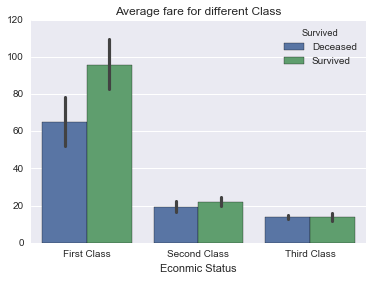

In [13]:
#make plot to fare distribution related to survival
sns.barplot(x=titanic.Pclass.map({1:'First Class', 2:'Second Class', 3:'Third Class'}),
            y=titanic.Fare,hue=titanic.Survived.map({0:'Deceased',1:'Survived'}),
            estimator=np.mean,order=['First Class','Second Class','Third Class'])
plt.ylabel("")
plt.xlabel("Econmic Status")
plt.title("Average fare for different Class");

Clearly, I can see that number of people in 3rd class (low class) is 2.5 times larger than people in 2nd class (middle class) and 1st class (high class). The interesting point in this graph is about the average fare in those class. In low class, there is no difference in average fare which makes life and death nondifferent. So does middle class. However, there is clear difference in high class when the survival group pay higher average fare than nonsurvival group. The explaination for this observation could be:

- In top class, there were more women and children than men so they had priority to be alive.
- In top class, people who paid more, stayed in the cabin with close to survival boat and it increased their chance of survival in this tragedy.

For the 1st assumption, I easily check by study about the gender in top class group.

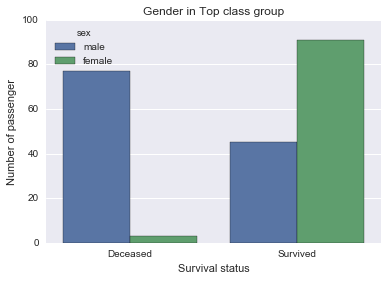

In [14]:
#make plot to gender distribution related to survival in class 1
data4 = titanic.groupby(['Survived','Pclass']).Sex.apply(pd.value_counts)
data4 = data4.reset_index()
data4 = data4.rename(columns = {'level_2':'sex'})
sns.barplot(x=data4.Survived.map({0:'Deceased',1:'Survived'}),
            y='Sex',hue='sex',data=data4[data4['Pclass']==1])
plt.ylabel("Number of passenger")
plt.xlabel("Survival status")
plt.title("Gender in Top class group")
plt.show()

In total, the number of men is 1.5 times larger than women in top class. HOwever, more than 90% of women and 30% of men were survived in this tragedy. It could be the case that 30% is male children. I can quickly check the age distrubiton in that 30%.

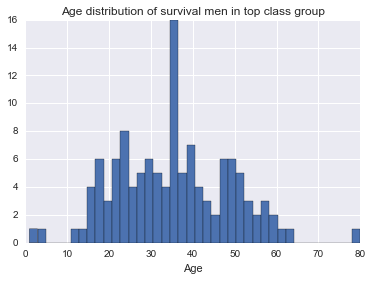

In [15]:
#Make plot to age distribution related to survival in male class 1
titanic[(titanic['Survived']==1) & (titanic['Pclass']==1)].Age.hist(bins = 40)
plt.title('Age distribution of survival men in top class group')
plt.xlabel('Age')
plt.show()

It looks weird in this above histogram when there is a huge spike in the middle. It can be caused by the missing values that was filled by mean or median. In order to verify the correction of this plot, I do additional analysis.

In [16]:
#Find the index of passenger whose age is in range 34 to 36.
titanic[(titanic['Survived']==1) & (titanic['Pclass']==1)&(titanic['Age'] > 34)&(titanic['Age'] <= 36)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
230,231,1,1,"Harris, Mrs. Henry Birkhardt (Irene Wallach)",female,35.0,1,0,36973,83.4750,C83,S
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
269,270,1,1,"Bissette, Miss. Amelia",female,35.0,0,0,PC 17760,135.6333,C99,S
325,326,1,1,"Young, Miss. Marie Grice",female,36.0,0,0,PC 17760,135.6333,C32,C
383,384,1,1,"Holverson, Mrs. Alexander Oskar (Mary Aline To...",female,35.0,1,0,113789,52.0000,NaN,S
390,391,1,1,"Carter, Mr. William Ernest",male,36.0,1,2,113760,120.0000,B96 B98,S
486,487,1,1,"Hoyt, Mrs. Frederick Maxfield (Jane Anne Forby)",female,35.0,1,0,19943,90.0000,C93,S
512,513,1,1,"McGough, Mr. James Robert",male,36.0,0,0,PC 17473,26.2875,E25,S
540,541,1,1,"Crosby, Miss. Harriet R",female,36.0,0,2,WE/P 5735,71.0000,B22,S


In [17]:
#Find the index of passenger whose age is unknown.
data1 = titanic[(titanic['Survived']==1) & (titanic['Pclass']==1)]
data1.loc[pd.isnull(data1.Age)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C
55,56,1,1,"Woolner, Mr. Hugh",male,NaN,0,0,19947,35.5000,C52,S
166,167,1,1,"Chibnall, Mrs. (Edith Martha Bowerman)",female,NaN,0,1,113505,55.0000,E33,S
256,257,1,1,"Thorne, Mrs. Gertrude Maybelle",female,NaN,0,0,PC 17585,79.2000,NaN,C
298,299,1,1,"Saalfeld, Mr. Adolphe",male,NaN,0,0,19988,30.5000,C106,S
306,307,1,1,"Fleming, Miss. Margaret",female,NaN,0,0,17421,110.8833,NaN,C
334,335,1,1,"Frauenthal, Mrs. Henry William (Clara Heinshei...",female,NaN,1,0,PC 17611,133.6500,NaN,S
375,376,1,1,"Meyer, Mrs. Edgar Joseph (Leila Saks)",female,NaN,1,0,PC 17604,82.1708,NaN,C
457,458,1,1,"Kenyon, Mrs. Frederick R (Marion)",female,NaN,1,0,17464,51.8625,D21,S
507,508,1,1,"Bradley, Mr. George (""George Arthur Brayton"")",male,NaN,0,0,111427,26.5500,NaN,S


Clearly, the index of two tables are different which can be concluded that my plot in cell 15 is not biased because of filling missing values.

So this group mostly had teenager and men (from 20 to 60). It had only 2 children.

So my 1st assumption is not correct. There are more men than women in top-class group. The influence of age in this group is low (only 2 children). The cause of difference in life and death is that up to 30% of men in top-class were survived.

The verification for my 1st assumption is clear. Continously, I want to check my 2nd theory: the relation between fare and cabin on Titanic.

In [18]:
(titanic[(titanic.Pclass == 1)].groupby([titanic.Cabin.str[:1],'Survived']).Fare.mean().unstack())

Survived,0,1
Cabin,,
A,35.496350,44.341071
B,57.137500,132.832026
C,99.972396,100.274046
D,59.613086,64.505123
E,48.460714,58.571067
T,35.500000,NaN


We see from the table above, cabin with prefix C is the most expensive one in average. I found that survival passengers in cabin B and C paid even double price than others. Will it guarantee for the surival ?

In [19]:
(titanic[(titanic.Pclass == 1)].groupby([titanic.Cabin.str[:1],'Survived']).PassengerId.count().unstack())

Survived,0,1
Cabin,,
A,8.0,7.0
B,12.0,35.0
C,24.0,35.0
D,7.0,22.0
E,7.0,18.0
T,1.0,NaN


The answer is NO. As we can see on the table above, the ratio of cabin B and C is the same to others like D or E, life/death = 3. Cabin A and T have the worst ratio. It is difficult to conclude that those cabin are related to the survival chance since the size of sample is small. I need more data for further analysis. There are a lot of missing data in Cabin section which prevent the correction of my analysis.

For the last analysis, I choose the passenger location or Embarked catergory.

In [20]:
titanic.groupby('Embarked').Survived.mean()

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64

I choose Chi-Square Test of Independent to determine whether the distribution of the Embarked variables are related to others.
- H0: The survivability and Embarkation Point are independent values.
- H1: The survivability and Embarkation Point are related.

In [21]:
ts.compute_freq_chi2(titanic.Survived,titanic.Embarked)

Frequency table
----------------------------
Embarked   C   Q    S
Survived             
0         75  47  427
1         93  30  217
----------------------------
('ChiSquare test statistic: ', 26.489149839237619)
('p-value: ', 1.769922284120912e-06)


From the result above, chi-square value is high which results in small p-value (close to 0). Therefore, it is possible to reject the null hypothesis which means that the Embarkation Point is related to the survivabilty. So passengers who have Embarkation Point in Cherbourg will have better chance to survive in this tragedy.

## Conclusion

From these observations, I found that the survival chance is related to several factors. The survivabilty will be based on:
    - Gender are women and children.
    - Stay in top class.
    - From Cherbourg.
Those observations is good enough (visualization, statistical test)  to answer my main question about the survival chance.

- There is also limitation in my analysis. The 687 missing values is the obstacle to produce an analysis in Cabin section and I would expect to have more samples to test again. Moreover, I did not analyze the other category in family relation (SibSp,Parch). I consider those variables to be bias because the explaination in the description of the data:
    > With respect to the family relation variables (i.e. sibsp and parch) some relations were ignored.
- Because of this limitation, it is very dangerous to analysis those variables if concerning about survivability.